<h1> Model 2: Decision Tree </h1>

<h2> Import the packages/classes and load the data </h2>

In [28]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve, GridSearchCV, StratifiedKFold, cross_val_predict, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Import change_summary
changelog = pd.read_csv('../Changelogs/change_summary.csv').to_dict(orient='records')

# Change summary intialization and check
change_summary = pd.DataFrame(changelog)
pd.set_option('display.max_colwidth', None)
display(change_summary)  

In [ ]:
# Load cleaned data from CSV
df = pd.read_csv("../Data/cleaned_loan_data.csv")
df.head()

<h2> Data Prep </h2>

In [ ]:
# Split the data into features and target variable
X = df.drop(columns=['loan_status'])
y = df['loan_status']

In [ ]:
#Split the data into the draining and test sets 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

In [ ]:
# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Check for class imbalance
print(f"Class distribution in training set:\n{y_train.value_counts(normalize=True)}")
print(f"Class distribution in test set:\n{y_test.value_counts(normalize=True)}")

# Changelog addition
changelog.append({
    'column': 'numerical_columns',
    'change': 'Applied MinMaxScaler to training data; transformed test data using same scaler.',
    'rationale': 'Avoided data leakage by fitting scaler only on training data. Ensures proper model generalization and adheres to machine learning best practices.'
})


<h2> Build the Model </h2>


<h3> Base Model </h3>

In [ ]:
# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=3,random_state=42)
dt_model.fit(X_train_scaled, y_train)


# Visualize the Decision Tree
plt.figure(figsize=(20, 12))  
plot_tree(dt_model,
          filled=True,
          rounded=True,
          feature_names=X_train.columns,
          class_names=['Rejected', 'Approved'],
          fontsize=12,
          impurity=False,       
          proportion=True)      
plt.title("Decision Tree - Loan Approval Prediction", fontsize=16)
plt.tight_layout()
plt.show()



--- Base Model Evaluation ---

Decision Tree:
              precision    recall  f1-score   support

    Rejected       0.82      0.97      0.89     10499
    Approved       0.74      0.27      0.39      2999

    accuracy                           0.82     13498
   macro avg       0.78      0.62      0.64     13498
weighted avg       0.81      0.82      0.78     13498



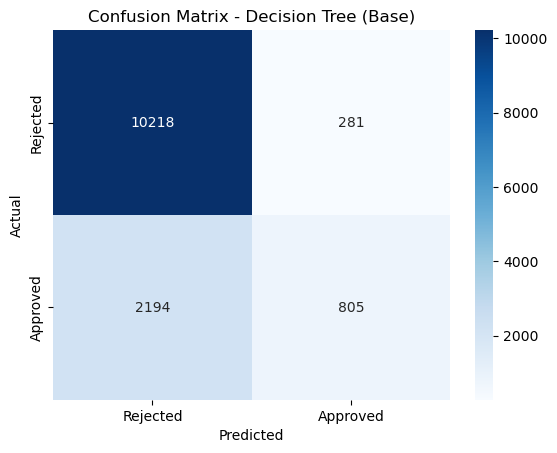

Accuracy Score:  0.8166395021484665
Precision Score:  0.7412523020257827
Recall Score:  0.2684228076025342
F1 Score:  0.39412484700122397
Specificity Score:  0.9732355462424993


In [12]:
# --- Model Validation ---

# Evaluate base models on the test set
print("\n--- Base Model Evaluation ---")

# Decision Tree
dt_predictions = dt_model.predict(X_test_scaled)
print("\nDecision Tree:")
print(classification_report(y_test, dt_predictions, target_names=['Rejected', 'Approved']))
cm_dt = confusion_matrix(y_test, dt_predictions)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree (Base)')
plt.show()

# Model Scores
print('Accuracy Score: ', accuracy_score(y_test, dt_predictions))
print('Precision Score: ', precision_score(y_test, dt_predictions))
print('Recall Score: ', recall_score(y_test, dt_predictions))
print('F1 Score: ', f1_score(y_test, dt_predictions))

tn = cm_dt[0,0]
fp = cm_dt[0,1]
specificity = tn/(tn+fp)
print('Specificity Score: ', specificity)

<h3> Apply Smote to the data and re-run the model</h3>

In [19]:
# SMOTE for handling class imbalance
smote = SMOTE(random_state=42)
X_smote_train, y_smote_train = smote.fit_resample(X_train_scaled, y_train)

# Check the class distribution after SMOTE
X_smote_test = X_test_scaled
y_smote_test = y_test

# Changelog entry for SMOTE
changelog.append({
    'column': 'subscribe_to_term_deposit',
    'change': f'Resampled training set with SMOTE (train shape now: {X_smote_train.shape}, test shape: {X_test.shape})',
    'rationale': 'Used SMOTE to correct class imbalance in training data for better model performance.'
})


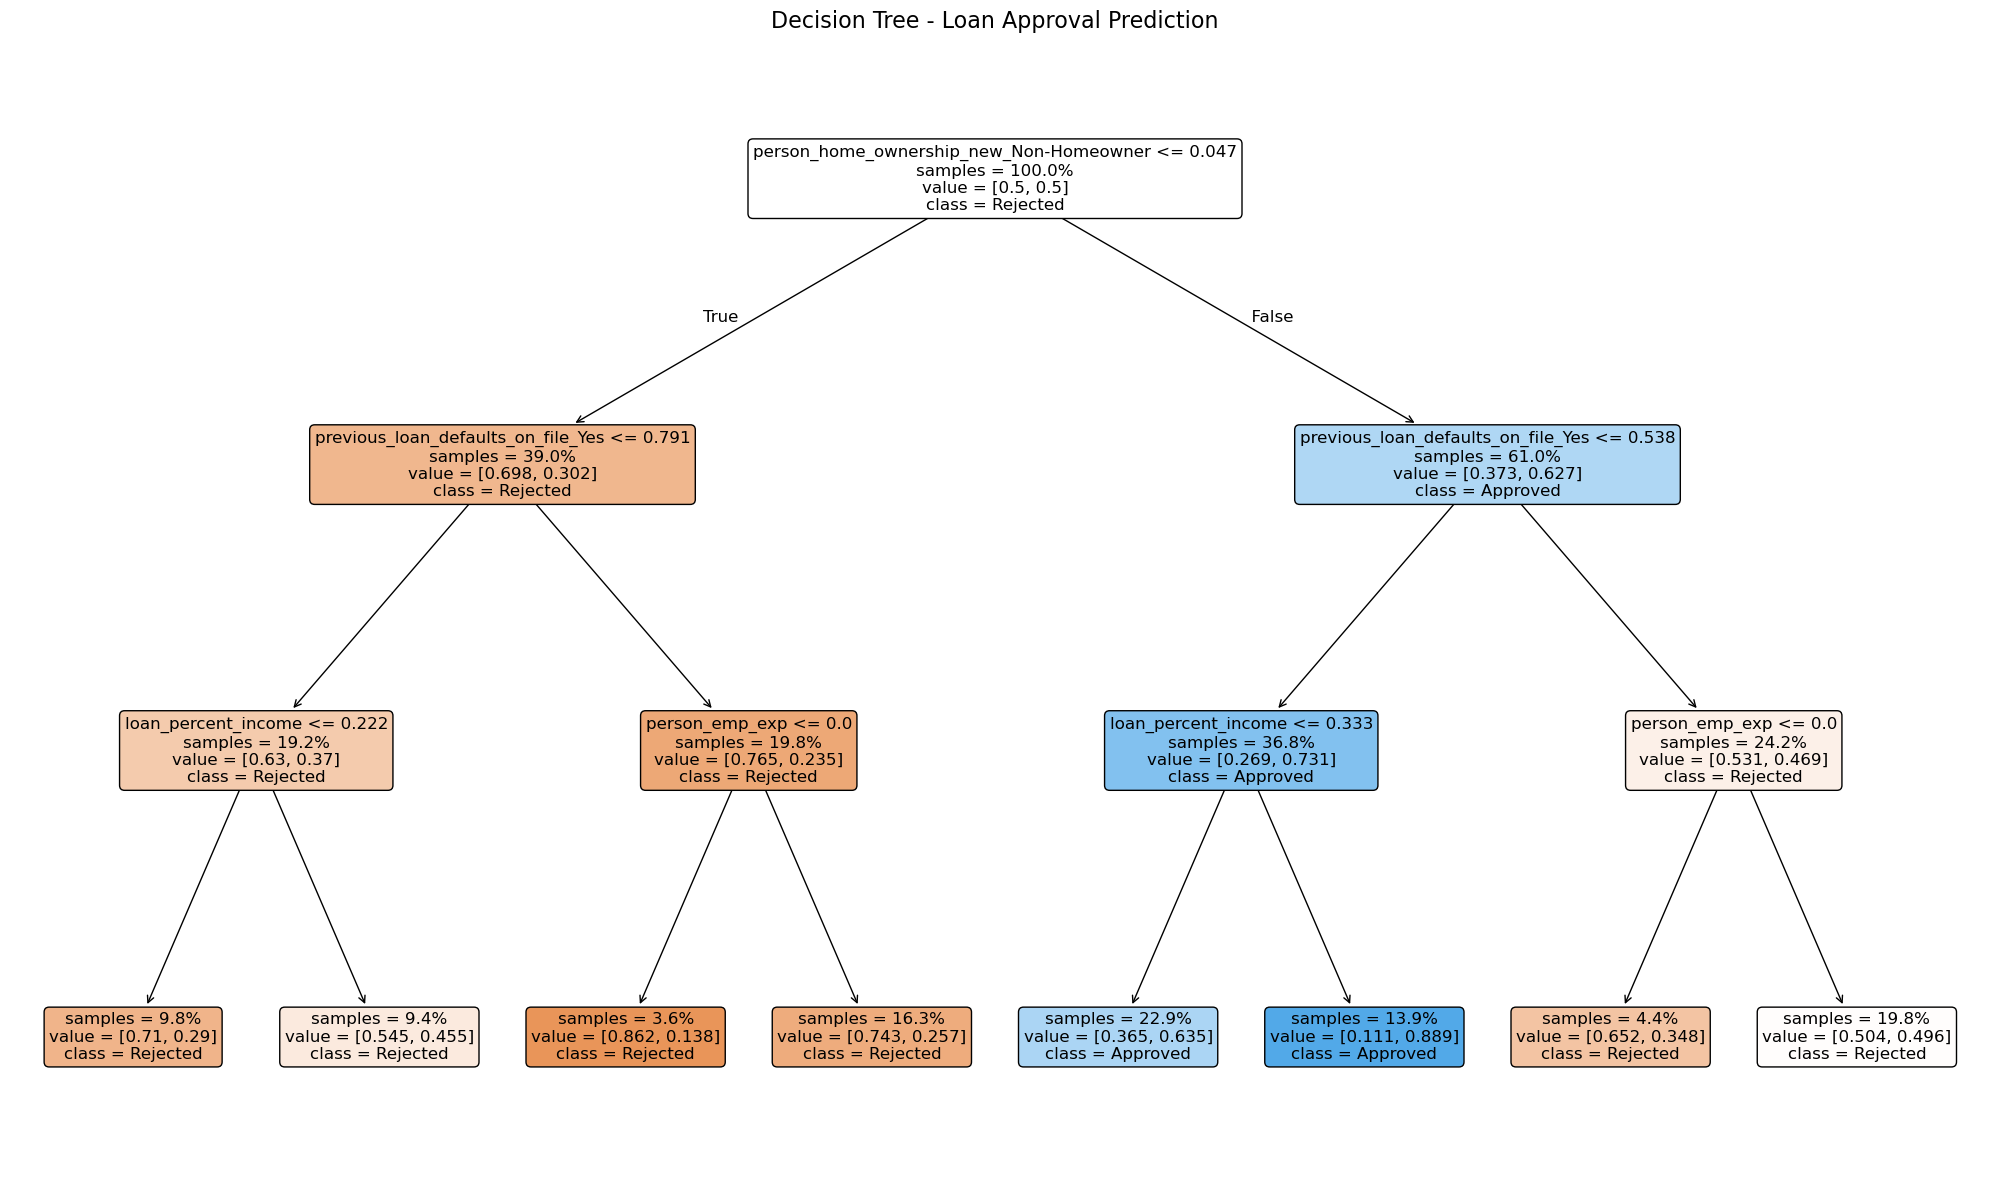

In [14]:

# Initialize the Decision Tree
smote_dt_model = DecisionTreeClassifier(max_depth=3,random_state=42)
smote_dt_model.fit(X_smote_train, y_smote_train)

# Visualize the Decision Tree

# Visualize the Decision Tree
plt.figure(figsize=(20, 12))  
plot_tree(smote_dt_model,
          filled=True,
          rounded=True,
          feature_names=X_train.columns,
          class_names=['Rejected', 'Approved'],
          fontsize=12,
          impurity=False,       
          proportion=True)      
plt.title("Decision Tree - Loan Approval Prediction", fontsize=16)
plt.tight_layout()
plt.show()


--- SMOTE DT Model Evaluation ---

Decision Tree:
              precision    recall  f1-score   support

    Rejected       0.86      0.80      0.83     10499
    Approved       0.44      0.54      0.49      2999

    accuracy                           0.74     13498
   macro avg       0.65      0.67      0.66     13498
weighted avg       0.77      0.74      0.75     13498



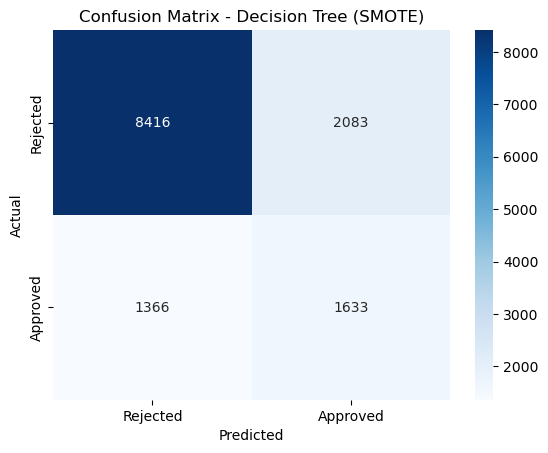

Accuracy Score:  0.7444806638020447
Precision Score:  0.43945102260495156
Recall Score:  0.5445148382794265
F1 Score:  0.48637379002233805
Specificity Score:  0.8016001523954662


In [16]:
# SMOTE Decision Tree Evaluation
print("\n--- SMOTE DT Model Evaluation ---")

# Decision Tree
smote_dt_predictions = smote_dt_model.predict(X_smote_test)
print("\nDecision Tree:")
print(classification_report(y_smote_test, smote_dt_predictions, target_names=['Rejected', 'Approved']))

smote_cm_dt = confusion_matrix(y_smote_test, smote_dt_predictions)
sns.heatmap(smote_cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree (SMOTE)')
plt.show()

# Model Scores
print('Accuracy Score: ', accuracy_score(y_test, smote_dt_predictions))
print('Precision Score: ', precision_score(y_test, smote_dt_predictions))
print('Recall Score: ', recall_score(y_test, smote_dt_predictions))
print('F1 Score: ', f1_score(y_test, smote_dt_predictions))

tn_smote = smote_cm_dt[0,0]
fp_smote = smote_cm_dt[0,1]
specificity_smote = tn_smote/(tn_smote+fp_smote)
print('Specificity Score: ', specificity_smote)

<h3> Model with Cross Validation </h3>

In [27]:
# Cross-validation for Decision Tree
dt_cv_scores = cross_val_score(DecisionTreeClassifier(max_depth=3, random_state=42),
                                X_train_scaled, y_train, cv=5, scoring='f1')

#Cross-validation for Decision Tree with smote
dt_cv_smote_scores = cross_val_score(DecisionTreeClassifier(max_depth=3, random_state=42),
                                X_smote_train, y_smote_train, cv=5, scoring='f1')

print("Decision Tree Cross-Validation Comparison:")
print(f"{'Dataset':<20}{'Mean CV F1 Score':<20}")
print(f"{'Original':<20}{dt_cv_scores.mean():<20.4f}")
print(f"{'SMOTE':<20}{dt_cv_smote_scores.mean():<20.4f}")


Decision Tree Cross-Validation Comparison:
Dataset             Mean CV F1 Score    
Original            0.3775              
SMOTE               0.6486              


In [26]:
#Create the model
dt_CV = DecisionTreeClassifier(max_depth=3, random_state=42)

#Set the number of splits
k_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Create pipeline to scale and run the model
pipeline = Pipeline([('scaler', scaler), ('model',dt_CV)])

#Run the cross-validation and evaluate the model
cv_scores = cross_val_score(pipeline, X, y, cv=k_folds, scoring='f1')
print("Cross-validation scores:", cv_scores)
print("Mean CV F1 Score:", cv_scores.mean())

Cross-validation scores: [0.38504258 0.37343173 0.37308411 0.40390173 0.3765227 ]
Mean CV F1 Score: 0.3823965718996837


In [29]:
#Create the model
dt_CV_smote = DecisionTreeClassifier(max_depth=3, random_state=42)

#Set the number of splits
k_folds_smote = KFold(n_splits=5, shuffle=True, random_state=42)

#Create pipeline to scale and run the model
pipeline_smote = ImbPipeline([('scaler', scaler), ('smote', smote), ('model',dt_CV_smote)])

#Run the cross-validation and evaluate the model
cv_scores_smote = cross_val_score(pipeline_smote, X, y, cv=k_folds_smote, scoring='f1')
print("Cross-validation scores:", cv_scores_smote)
print("Mean CV F1 Score:", cv_scores_smote.mean())

Cross-validation scores: [0.48410098 0.45687869 0.47619048 0.47465527 0.44715689]
Mean CV F1 Score: 0.46779646205467457


<h3> Hyperparameter Tuning </h3>

<h4> Original Data </h4>

In [30]:
print("\n--- Hyperparameter Tuning using Grid Search CV ---")

# Decision Tree
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(3, 15),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [3, 4, 5]
}
dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                               param_grid=dt_param_grid, cv=5, scoring='f1', n_jobs=-1)
dt_grid_search.fit(X_train_scaled, y_train)

print("\nDecision Tree Best Parameters:", dt_grid_search.best_params_)
dt_best_model = dt_grid_search.best_estimator_


--- Hyperparameter Tuning using Grid Search CV ---


/Applications/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Decision Tree Best Parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 10}



Logistic Regression (Tuned):
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     10499
           1       0.67      0.31      0.43      2999

    accuracy                           0.81     13498
   macro avg       0.75      0.64      0.66     13498
weighted avg       0.80      0.81      0.79     13498



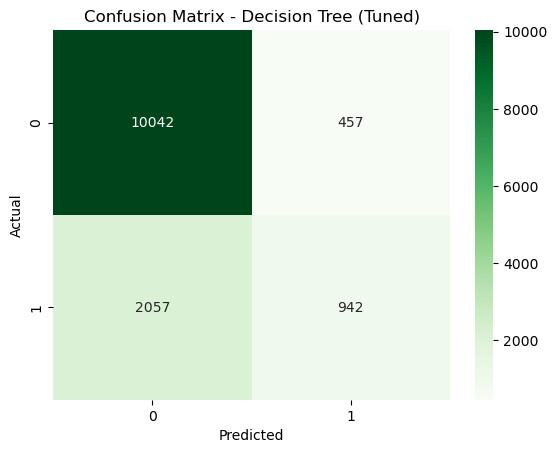

Accuracy Score:  0.8137501852126241
Precision Score:  0.6733380986418871
Recall Score:  0.31410470156718906
F1 Score:  0.42837653478854026
Specificity Score:  0.9564720449566625


In [32]:
# Define string labels for display
target_names = ['0', '1'] 

# Generate predictions
lr_tuned_predictions = dt_best_model.predict(X_test_scaled)

# Classification report
print("\nLogistic Regression (Tuned):")
print(classification_report(y_test, lr_tuned_predictions, target_names=target_names))

# Confusion matrix
cm_lr_tuned = confusion_matrix(y_test, lr_tuned_predictions, labels=[0, 1])
sns.heatmap(cm_lr_tuned, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree (Tuned)')
plt.show()

# Model Scores
print('Accuracy Score: ', accuracy_score(y_test, lr_tuned_predictions))
print('Precision Score: ', precision_score(y_test, lr_tuned_predictions))
print('Recall Score: ', recall_score(y_test, lr_tuned_predictions))
print('F1 Score: ', f1_score(y_test, lr_tuned_predictions))

tn_bm = cm_lr_tuned[0,0]
fp_bm = cm_lr_tuned[0,1]
specificity_bm = tn_bm/(tn_bm+fp_bm)
print('Specificity Score: ', specificity_bm)

<h4> Data with Smote Applied </h4>

In [33]:
# Decision Tree w Smote
dt_param_grid_smote = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(3, 15),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [3, 4, 5]
}
dt_grid_search_smote = GridSearchCV(DecisionTreeClassifier(random_state=42),
                               param_grid=dt_param_grid, cv=5, scoring='f1', n_jobs=-1)
dt_grid_search_smote.fit(X_smote_train, y_smote_train)

print("\nDecision Tree Best Parameters:", dt_grid_search_smote.best_params_)
dt_best_model_smote = dt_grid_search_smote.best_estimator_

/Applications/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Decision Tree Best Parameters: {'criterion': 'gini', 'max_depth': 14, 'min_samples_leaf': 3, 'min_samples_split': 10}



Logistic Regression (SMOTE Tuned):
              precision    recall  f1-score   support

           0       0.84      0.87      0.85     10499
           1       0.48      0.42      0.45      2999

    accuracy                           0.77     13498
   macro avg       0.66      0.64      0.65     13498
weighted avg       0.76      0.77      0.76     13498



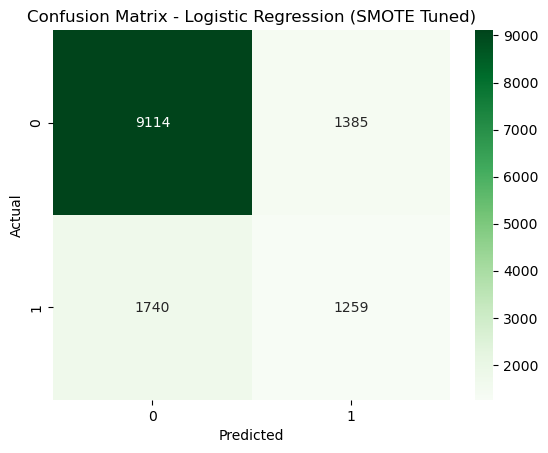

Accuracy Score:  0.7684842198844273
Precision Score:  0.47617246596066565
Recall Score:  0.41980660220073357
F1 Score:  0.4462165514797094
Specificity Score:  0.8680826745404324


In [34]:
# Define string labels for display
target_names = ['0', '1'] 

# Generate predictions
lr_tuned_pred_smote = dt_best_model_smote.predict(X_smote_test)

# Classification report
print("\nLogistic Regression (SMOTE Tuned):")
print(classification_report(y_test, lr_tuned_pred_smote, target_names=target_names))

# Confusion matrix
cm_lr_tuned_smote = confusion_matrix(y_test, lr_tuned_pred_smote, labels=[0, 1])
sns.heatmap(cm_lr_tuned_smote, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression (SMOTE Tuned)')
plt.show()

# Model Scores
print('Accuracy Score: ', accuracy_score(y_test, lr_tuned_pred_smote))
print('Precision Score: ', precision_score(y_test, lr_tuned_pred_smote))
print('Recall Score: ', recall_score(y_test, lr_tuned_pred_smote))
print('F1 Score: ', f1_score(y_test, lr_tuned_pred_smote))

tn_bm_smote = cm_lr_tuned_smote[0,0]
fp_bm_smote = cm_lr_tuned_smote[0,1]
specificity_bm_smote = tn_bm_smote/(tn_bm_smote+fp_bm_smote)
print('Specificity Score: ', specificity_bm_smote)

<h3> Learning Curve </h3>


--- Learning Curve ---


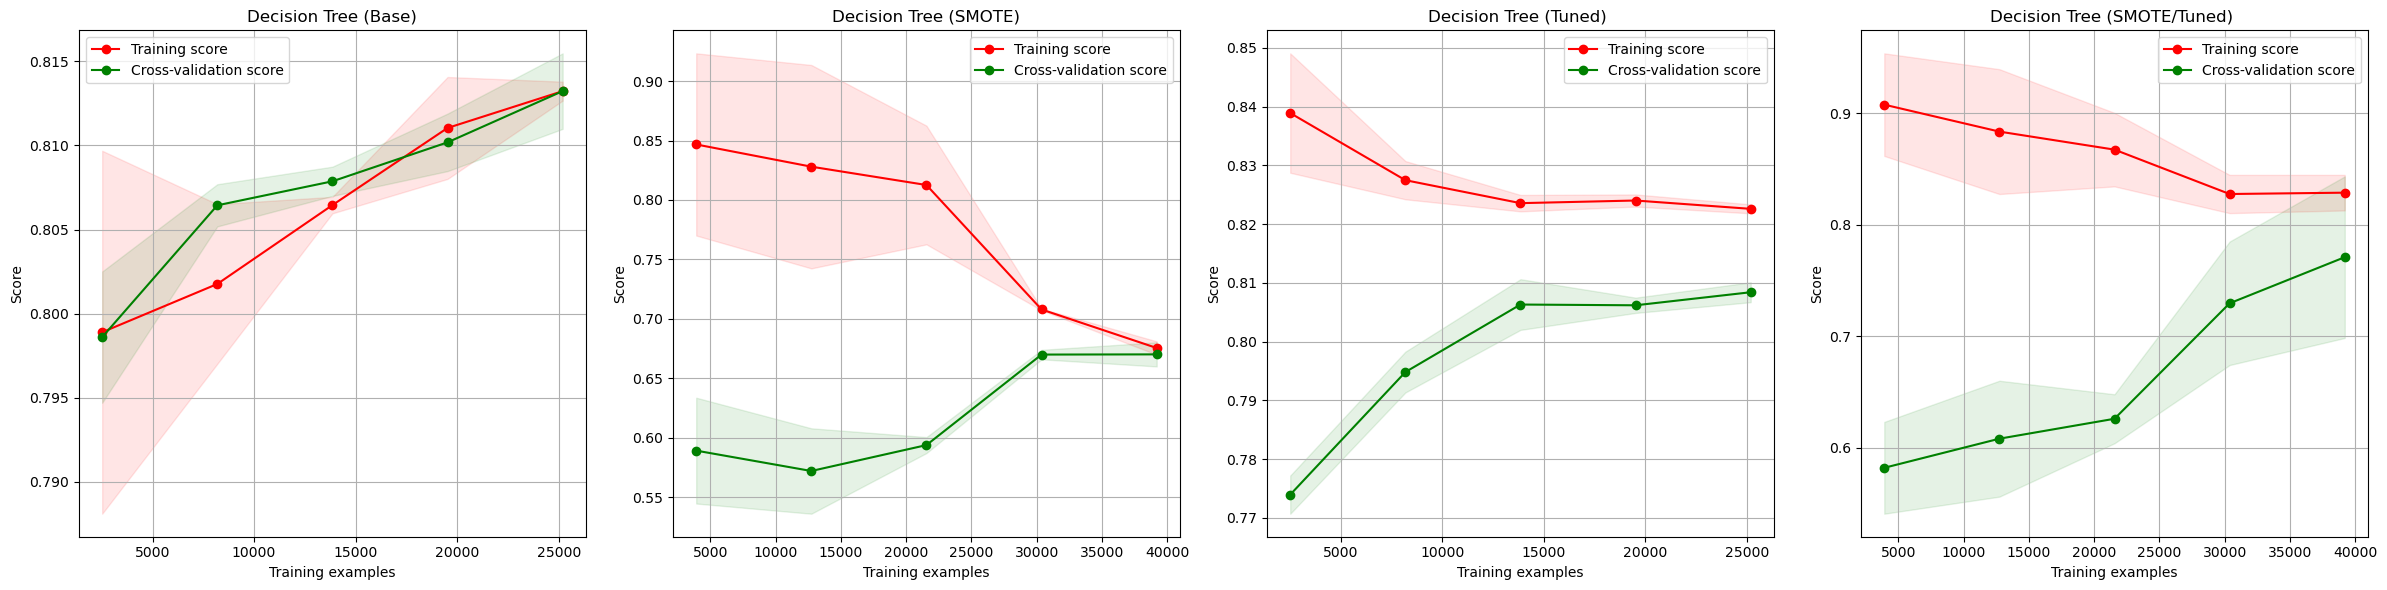

In [37]:
# --- Learning Curve ---

print("\n--- Learning Curve ---")

def plot_learning_curve(estimator, title, X, y, axes=None, train_sizes=np.linspace(0.1, 1.0, 5), cv=None, scoring='accuracy'):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 6))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=cv, scoring=scoring, n_jobs=-1
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes.set_title(title)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")
    axes.grid()
    axes.legend(loc="best")
    return plt

# Plot learning curves for different models
fig, axes = plt.subplots(1, 4, figsize=(24, 6))
# Original
plot_learning_curve(DecisionTreeClassifier(max_depth=3, random_state=42),
                    "Decision Tree (Base)",  
                    X_train_scaled, y_train, axes=axes[0], cv=5)

# SMOTE
plot_learning_curve(DecisionTreeClassifier(max_depth=3, random_state=42),
                    "Decision Tree (SMOTE)", 
                    X_smote_train, y_smote_train, axes=axes[1], cv=5)

# Tuned model
plot_learning_curve(dt_best_model, 
                    "Decision Tree (Tuned) ", 
                    X_train_scaled, y_train, axes=axes[2], cv=5)

# SMOTE Tuned model
plot_learning_curve(dt_best_model_smote, 
                    "Decision Tree (SMOTE/Tuned) ", 
                    X_smote_train, y_smote_train, axes=axes[3], cv=5)

plt.tight_layout()
plt.show()

